In [66]:
import sys
import os
import json
import ggseg
sys.path.append("../") # go to parent dir

import pandas as pd
import numpy as np
from scipy.stats import pearsonr 


from nsm_toolbox.src import network_diffusion_model, FKPP_model
from nsm_toolbox.src.find_optimal_timepoint import find_optimal_timepoint
from nsm_toolbox.src.ModelSelection import ModelSelection

from my_src import utils
from my_src import constants
from my_src.clinical_group import ClinicalGroup


%load_ext autoreload
%autoreload 2

figures_folder = "../writeup/figures/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
tau = pd.read_csv(constants.tau_filepath, names=["region", "suvr"], header=0)
target_data = tau["suvr"].values
# remove the subcortical regions, since these are affected by off-target binding of the tau-PET tracer
CORT_IDX = np.concatenate([np.arange(34), np.arange(49, 83)])
target_data = target_data[CORT_IDX]
target_data = utils.normalise_data(target_data)

t=np.arange(0, 50, 0.1)
gamma=1
region_list = constants.tau_region_raj_label
clinical_group_name = "CN"
participant = "avg"

optimal_parameters_df = utils.load_optimal_parameters_df(["WFKPP","FKPP"])
optimal_parameters_row = utils.get_optimal_parameters(optimal_parameters_df, "WFKPP", participant, clinical_group_name)
connectome_path = constants.connectome_filepath.format(clinical_group_name=clinical_group_name, participant=participant)

In [ ]:
model_names = list(constants.model_name_map.keys())[:-1]
for model_name in model_names:
    prediction = np.load(constants.prediction_filepath.format(model=model_name, clinical_group_name=clinical_group_name, participant="avg"))
    residual = prediction - target_data
    np.save(constants.residuals_filepath.format(
        clinical_group_name=clinical_group_name,
        participant=participant,
        model=model_name),
        residual)
    
    

In [71]:
clinical_group_name = constants.clinical_group_names[0]
participant = "avg"
model_names = ["FKPP","WFKPP"]

results = []


for use_weights in [True, False]:
    if use_weights:
        model_name = "WFKPP"
        amyloid_data = pd.read_csv(constants.amyloid_filepath, names=["region", "suvr"], header=0)
        model = FKPP_model.FKPP(connectome_fname=connectome_path,  # set up our network diffusion model class
                                    t=t,
                                    gamma=gamma,
                                    ref_list=region_list,
                                    weights=amyloid_data["suvr"].values)
    else:
        model_name = "FKPP"
        model = FKPP_model.FKPP(connectome_fname=connectome_path,  # set up our network diffusion model class
                                    t=t,
                                    gamma=gamma,
                                    ref_list=region_list)
    model.seed_region = optimal_parameters_row["seed_region"]
    model.alpha = optimal_parameters_row["alpha"]
    model_output = model.run_FKPP()
    min_idx, prediction, SSE = find_optimal_timepoint(model_output, target_data)
    residuals = prediction - target_data
    r = pearsonr(prediction, target_data)[0]
    results.append({
        "clinical_group_name": clinical_group_name,
        "model_name": model_name,
        "optimal_seed": optimal_parameters_row["seed_region"],
        "optimal_alpha": optimal_parameters_row["alpha"],
        "SSE": SSE,
        "r": r,
        "residuals": residuals,
        "prediction": prediction,
        "target_data": target_data,
    })

results = pd.DataFrame(results)
# results = results[["clinical_group_name","model_name","SSE","r"]]
results["SSE"] = results["SSE"].round(2)
results["r"] = results["r"].round(3)
results["clinical_group_name"] = results["clinical_group_name"].map(constants.clinical_group_name_map)
results["model_name"] = results["model_name"].map(constants.model_name_map)

In [73]:
results

,clinical_group_name,model_name,optimal_seed,optimal_alpha,SSE,r,residuals,prediction,target_data
0,CN,A$\beta$-FKPP,Entorhinal,0.41888,1.86,0.720,"[-0.1988960177462431, 0.08604997994922667, -0....","[0.6513917975697512, 0.23179001189522014, 0.21...","[0.8502878153159943, 0.14574003194599347, 0.41..."
1,CN,FKPP,Entorhinal,0.41888,2.40,0.619,"[-0.3109358264715253, 0.1048528881094016, -0.1...","[0.539351988844469, 0.2505929200553951, 0.2515...","[0.8502878153159943, 0.14574003194599347, 0.41..."


In [84]:
difference_in_residuals = (results.iloc[1]["prediction"] - results.iloc[0]["prediction"])/results.iloc[0]["prediction"]*100
np.save(constants.residuals_filepath.format(
    clinical_group_name=clinical_group_name,
    participant=participant,
    model="MFKPP-WFKPP"),
    difference_in_residuals)

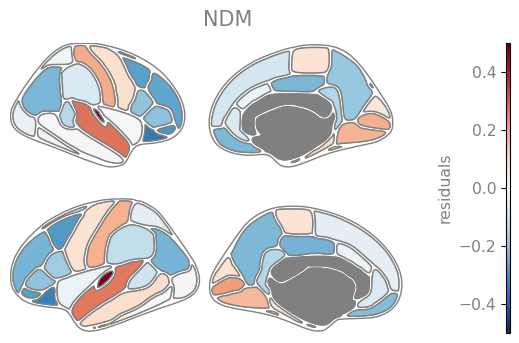

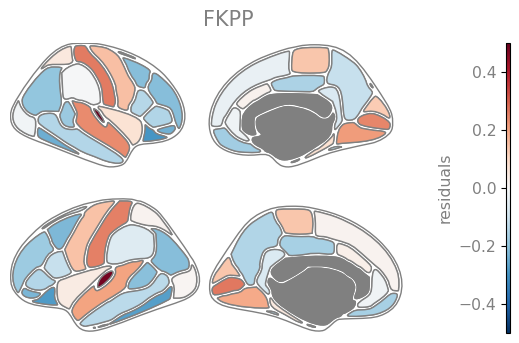

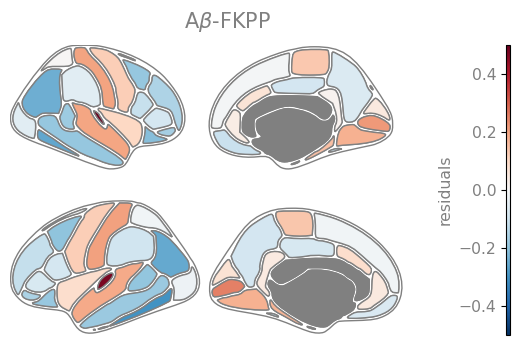

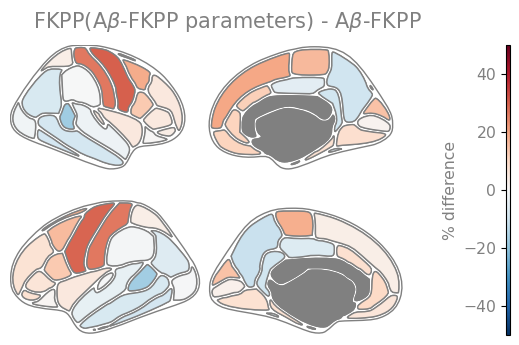

In [86]:
model_names = ["NDM", "FKPP", "WFKPP", "MFKPP-WFKPP"]
ggseg_region_list = pd.read_csv( "../data/TauRegionList_ggseg.csv")["Raj_label_ggseg"].tolist()  
ggseg_region_list = list(map(lambda x: ggseg_region_list[x],CORT_IDX))
for model_name in model_names:
    residuals = np.load(constants.residuals_filepath.format(
        clinical_group_name=clinical_group_name,
        participant=participant,
        model=model_name))
    residuals_mapped = dict(zip(ggseg_region_list, residuals))
    vminmax = [-50, 50] if model_name == "MFKPP-WFKPP" else [-0.5, 0.5]
    ggseg.plot_dk(residuals_mapped, cmap='RdBu_r',
                    background='white', 
                    edgecolor='grey', bordercolor='w',
                    vminmax = vminmax,   
                    figsize=(5,5),
                    ylabel= '% difference' if model_name == "MFKPP-WFKPP" else 'residuals', 
                    title=constants.model_name_map[model_name],
                    )

In [76]:
model_output = model.run_FKPP()
min_idx, prediction, SSE = find_optimal_timepoint(model_output, target_data)

In [80]:
model_name = "FKPP"
region_list = constants.tau_region_raj_label
region_list = list(map(lambda x: region_list[x],CORT_IDX))
residuals = np.load(constants.residuals_filepath.format(
    clinical_group_name=clinical_group_name,
    participant=participant,
    model=model_name))
residuals_mapped = pd.DataFrame(residuals, index=region_list, columns=["residuals"])

In [90]:
import numpy as np
import pandas as pd

# Use the correct region list
region_list = constants.tau_region_raj_label
region_list = list(map(lambda x: region_list[x], CORT_IDX))

# Process the models
main_models = ["NDM", "FKPP", "WFKPP"]
model_regions = {}

for model_name in main_models:
    # Load residuals
    residuals = np.load(constants.residuals_filepath.format(
        clinical_group_name=clinical_group_name,
        participant=participant,
        model=model_name))
    
    # Create a series with residuals and region names
    residuals_series = pd.Series(residuals, index=region_list)
    
    # Get top 3 overpredicted and underpredicted
    top_over = residuals_series.nlargest(3)
    top_under = residuals_series.nsmallest(3)
    
    # Store in dictionary
    model_regions[model_name] = {
        'over': top_over,
        'under': top_under
    }

# Also process MFKPP-WFKPP
diff_model = "MFKPP-WFKPP"
diff_residuals = np.load(constants.residuals_filepath.format(
    clinical_group_name=clinical_group_name,
    participant=participant,
    model=diff_model))

diff_series = pd.Series(diff_residuals, index=region_list)
diff_top_over = diff_series.nlargest(3)
diff_top_under = diff_series.nsmallest(3)

# Generate LaTeX table for main models - simplified version
main_table = r"""\begin{table}[ht]
\centering
\caption{Regions with largest prediction errors across models in CN group}
\label{tab:residuals_main}
\begin{tabular}{c|p{4.5cm}|p{4.5cm}|p{4.5cm}}
\toprule
 & \textbf{NDM} & \textbf{FKPP} & \textbf{WFKPP} \\
\midrule
\multirow{3}{*}{\rotatebox[origin=c]{90}{\textbf{Over}}} """

# Add overpredicted regions - simplified
for i in range(3):
    cells = []
    
    for model in main_models:
        region = model_regions[model]['over'].index[i].replace("_", " ")
        cells.append(f"\\textcolor{{red}}{{{region}}}")
    
    row_start = "& " if i > 0 else ""
    main_table += f"\n{row_start}{cells[0]} & {cells[1]} & {cells[2]} \\\\"
    if i == 2:
        main_table += r" \midrule"

# Add underpredicted regions - simplified
main_table += r"""
\multirow{3}{*}{\rotatebox[origin=c]{90}{\textbf{Under}}} """

for i in range(3):
    cells = []
    
    for model in main_models:
        region = model_regions[model]['under'].index[i].replace("_", " ")
        cells.append(f"\\textcolor{{blue}}{{{region}}}")
    
    row_start = "& " if i > 0 else ""
    main_table += f"\n{row_start}{cells[0]} & {cells[1]} & {cells[2]} \\\\"

main_table += r"""
\bottomrule
\end{tabular}
\end{table}"""

# Generate LaTeX table for the difference model - simplified version
diff_table = r"""\begin{table}[ht]
\centering
\caption{Regions with largest differences between MFKPP and WFKPP in CN group}
\label{tab:residuals_diff}
\begin{tabular}{c|p{12cm}}
\toprule
 & \textbf{MFKPP-WFKPP} \\
\midrule
\multirow{3}{*}{\rotatebox[origin=c]{90}{\textbf{Higher in}\\\textbf{MFKPP}}} """

# Add regions with higher values in MFKPP - simplified
for i in range(3):
    region = diff_top_over.index[i].replace("_", " ")
    value = diff_top_over.values[i]
    row_start = "& " if i > 0 else ""
    diff_table += f"\n{row_start}\\textcolor{{red}}{{{region}}} ({{{value}}}) \\\\"
    if i == 2:
        diff_table += r" \midrule"

# Add regions with higher values in WFKPP - simplified
diff_table += r"""
\multirow{3}{*}{\rotatebox[origin=c]{90}{\textbf{Higher in}\\\textbf{WFKPP}}} """

for i in range(3):
    region = diff_top_under.index[i].replace("_", " ")
    value = diff_top_under.values[i]
    row_start = "& " if i > 0 else ""
    diff_table += f"\n{row_start}\\textcolor{{blue}}{{{region}}} ({{{value}}}) \\\\"

diff_table += r"""
\bottomrule
\end{tabular}
\end{table}"""

# Print the LaTeX tables
print("LaTeX for main models:")
print(main_table)
print("\nLaTeX for difference model:")
print(diff_table)

# Add latex packages needed for these formatting improvements
print("\nAdd these to your preamble:")
print(r"""\usepackage{multirow}
\usepackage{graphicx}
\usepackage{xcolor}""")

LaTeX for main models:
\begin{table}[ht]
\centering
\caption{Regions with largest prediction errors across models in CN group}
\label{tab:residuals_main}
\begin{tabular}{c|p{4.5cm}|p{4.5cm}|p{4.5cm}}
\toprule
 & \textbf{NDM} & \textbf{FKPP} & \textbf{WFKPP} \\
\midrule
\multirow{3}{*}{\rotatebox[origin=c]{90}{\textbf{Over}}} 
\textcolor{red}{Transversetemporal R} & \textcolor{red}{Transversetemporal R} & \textcolor{red}{Transversetemporal R} \\
& \textcolor{red}{Transversetemporal L} & \textcolor{red}{Transversetemporal L} & \textcolor{red}{Transversetemporal L} \\
& \textcolor{red}{Temporalpole R} & \textcolor{red}{Pericalcarine L} & \textcolor{red}{Pericalcarine L} \\ \midrule
\multirow{3}{*}{\rotatebox[origin=c]{90}{\textbf{Under}}} 
\textcolor{blue}{Lateralorbitofrontal R} & \textcolor{blue}{Lateralorbitofrontal R} & \textcolor{blue}{Inferiortemporal L} \\
& \textcolor{blue}{Lateralorbitofrontal L} & \textcolor{blue}{Lateralorbitofrontal L} & \textcolor{blue}{Inferiortemporal R} \\